In [1]:
%pylab inline

from scipy.stats.distributions import skewnorm
from scipy.optimize import leastsq
from scipy.ndimage import gaussian_filter
from densitycontour import densitycontour
from string import join

import itertools as it

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("font", size=20)
rc("text", usetex=True, **{"latex.preamble":r"\usepackage{amsmath},\usepackage{times},\usepackage{eulervm}", "hinting":"native"})
rc("figure", figsize=(5,5))
rc("axes", linewidth=0.3)
rc("xtick.major", width=0.3)
rc("ytick.major", width=0.3)
rc("xtick.minor", width=0.3)
rc("ytick.minor", width=0.3)
rc("xtick", labelsize="x-small")
rc("ytick", labelsize="x-small")
rc("hatch", linewidth=0.5)
rc("grid", linewidth=0.3)
rc("savefig", format="pdf", dpi=50, bbox="tight")

In [3]:
# modelo real
def real_model(x, params):
    return x**params[0]+params[1]
# modelo propuesto
def model(x, params):
    return params[0]*x+params[1]
# definir verosimilitud del modelo asumido para reproducir cada observación
def lik_i(x, y, sigma, params):
    return 1.0/sqrt(2*pi*sigma**2)*exp(-((model(x, params)-y)/(2*sigma))**2)
# definir verosimilitud verdadera del modelo asumido para reproducir cada observación
def real_lik_i(x, y, sigma, params):
    return 1.0/sqrt(2*pi*sigma**2)*exp(-((real_model(x, params)-y)/(2*sigma))**2)
# definir prior objetivo
def naive_prior(m, b, **kwargs):
    return ones(m.shape)*1.0/(m.max()-m.min())*1.0/(b.max()-b.min())
# definir prior informativo
def inf_prior(m, b, mu_m=1.0, sigma_m=0.5, mu_b=-1.0, sigma_b=1.0):
    return normpdf(m, mu_m, sigma_m) * normpdf(b, mu_b, sigma_b)
# definir clipping
def last(nbin, span):
    return span[0], span[-1]+diff(span)/nbin
# definir log enmascarado
def masked_log(PDF):
    PDF_ = copy(PDF)
    PDF_[PDF_==0.0] = 1.0
    PDF_ = log(PDF_)
    PDF_[PDF_==0.0] = np.nan
    return PDF_
# definir integral volumetrica
def integrate_vol(support, PDF, axis=None):
    volume = copy(PDF)
    if axis==None:
        volume = (0.5*(volume[:-1]+volume[1:])*diff(support[0],axis=0)).sum(axis=0)
        volume = (0.5*(volume[:-1]+volume[1:])*diff(unique(support[1]))).sum()
    else:
        indices = arange(volume.shape[axis], dtype=np.int)
        h = 0.5*(volume.take(indices[1:],axis)+volume.take(indices[:-1],axis))
        volume = (h*diff(support[axis],axis=axis)).sum(axis)
    return volume
# definir normalización al máximo valor
def norm_to_max(PDF, return_min_max=False):
    PDF_ = copy(PDF)
    min_ = PDF_.min()
    if any(PDF!=PDF[0]):
        PDF_ -= min_
    max_ = PDF_.max()
    PDF_ /= max_
    if return_min_max: return PDF_, min_, max_
    else: return PDF_
# definir normalización al volumen
def norm_to_vol(support, PDF, return_vol=False):
    PDF_ = copy(PDF)
    volume = integrate_vol(support, PDF_)
    PDF_ /= volume
    if return_vol: return PDF_, volume
    else: return PDF_
# definir calculo del nivel ~ percentile
def percentile_to_level(X, Y, PDF, percentile, tol=1e-4, max_iter=1000):
    PDF_ = copy(PDF)
    PDF_, Z_min, Z_max = norm_to_max(PDF_, return_min_max=True)
    if percentile==100.0: return Z_min
    if percentile==0.0: return Z_max
    
    volume = integrate_vol([X,Y], PDF_)
    step = -0.1
    delta = 999.9
    levels = [1.0]
    pers = [0.0]
    while True:
        mask = PDF_>=levels[-1]+step
        Z = copy(PDF_)
        Z[~mask] = 0.0
        pseudo_vol = integrate_vol([X,Y], Z)
        levels.append(levels[-1]+step)
        pers.append(pseudo_vol/volume)
        delta = percentile-pers[-1]
        if tol>abs(delta) or len(levels)>=max_iter: break
        if (delta>0 and step>0) or (delta<0 and step<0): step *= -1.0
        if levels[-1]+step in levels: step *= 0.5
    levels[-1] *= Z_max
    if any(PDF!=PDF[0]):
        levels[-1] += Z_min
    return levels[-1]
# definir función para muestrear distribuciones arbitrarias
def rejection_sampling(support, PDF, n_samples=100, return_grid=False, grid_steps=None):
    X, Y = support
    Z, Z_min, Z_max = norm_to_max(copy(PDF), return_min_max=True)
    
    Z_prop = random.rand(*Z.shape)
    mask = Z_prop<=Z
    x, y, z = X[mask].ravel(), Y[mask].ravel(), Z[mask].ravel()
    z *= Z_max
    z += Z_min
    if n_samples<mask.sum():
        idx = random.choice(arange(mask.sum(), dtype=np.int), size=n_samples, replace=False)
        x, y, z = x[idx], y[idx], z[idx]
    if return_grid:
        ranges = [(r.min(),r.max()) for r in (x,y)]
        if grid_steps==None: grid_steps_ = (100,)*len(ranges)
        else: grid_steps_ = grid_steps
        xi, yi = [linspace(ranges[i][0],ranges[i][1],grid_steps_[i]) for i in xrange(len(ranges))]
        zi = griddata(x, y, z, xi, yi, interp="linear")
        return x, y, xi, yi, zi
    else:
        return x, y
# definir función para muestrear el espacio de observables de acuerdo a la PDF
def model_sampling(support, PDF, X, model, max_samples=100, bins=100):
    PDF_ = copy(PDF)
    PDF_ = norm_to_max(PDF_)*max_samples
    
    X_par, Y_par = support
    X_obs, Y_obs = [], []
    for i,j in it.product(xrange(X_par.shape[0]),xrange(Y_par.shape[1])):
        x_par, y_par, n = X_par[i,j], Y_par[i,j], PDF_[i,j]
        
        if n>=1:
            X_obs.append(repeat(X,n))
            Y_obs.append(repeat(model(X,[x_par,y_par]),n))
        
    X_obs = concatenate(X_obs)
    Y_obs = concatenate(Y_obs)
    H, xe, ye = histogram2d(X_obs, Y_obs, bins, range=((X_obs.min(),X_obs.max()),(Y_obs.min(),Y_obs.max())))
    X_cen = 0.5*diff(xe)+xe[:-1]
    Y_cen = 0.5*diff(ye)+ye[:-1]
    return H.T, X_cen, Y_cen

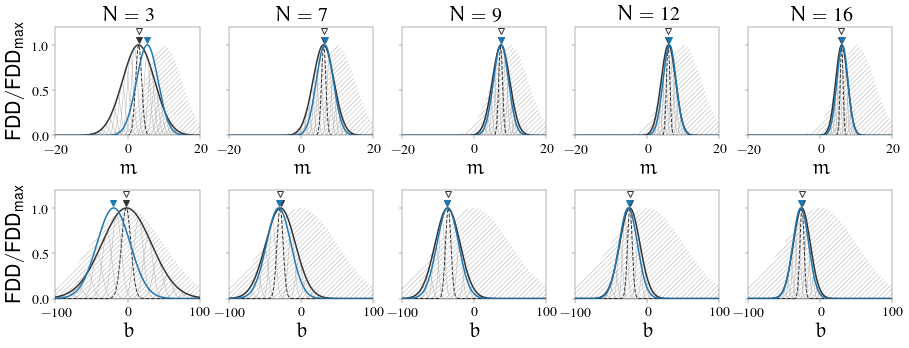

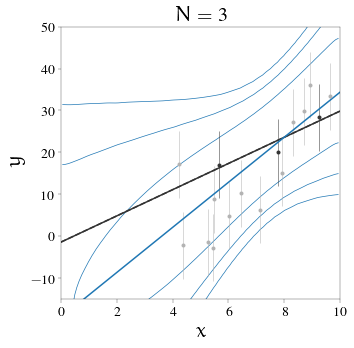

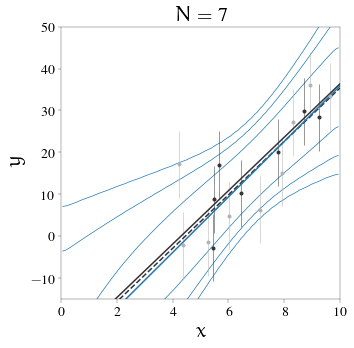

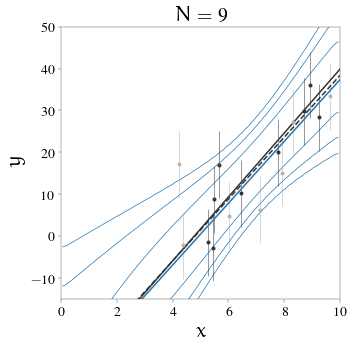

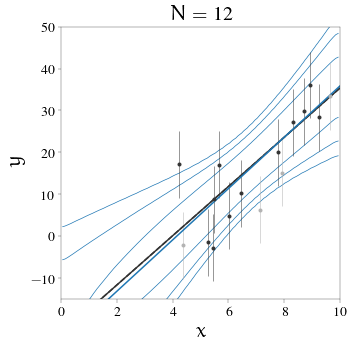

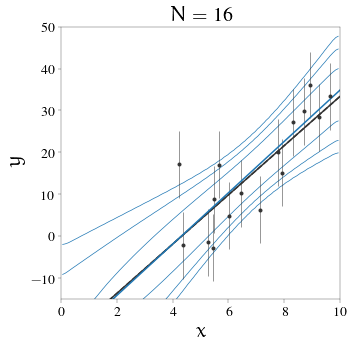

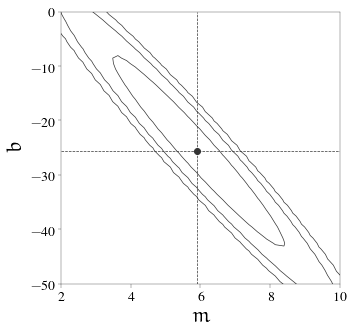

In [4]:
# ======================================== DATA SIMULATION =============================================================
random.seed(0)
real_params = (1.5, 0.0)
percentiles = [0.99, 0.95, 0.68]
range_x = (0, 10)
range_y = (-15, 50)
range_m, range_b = (-50.0, +50.0), (-200.0, +200.0)
range_pdf = (0.0, 1.2)
N_obs, N_uni, N_par = 20, 400, 400
shape = (N_uni, N_par, N_par)
X = linspace(range_x[0], range_x[1], shape[0])
M = linspace(range_m[0], range_m[1], shape[1])
B = linspace(range_b[0], range_b[1], shape[2])
sk, mu, sigma = 0.0, 0.0, 8.0
x = sort(X[0]+random.rand(N_obs)*(X[-1]-X[0]))
y = real_model(x, real_params) + skewnorm.rvs(sk, mu, sigma, size=N_obs)
mask_linear = x>4.0
x_obs = x[mask_linear]
y_obs = y[mask_linear]
XX_obs, MM_obs, BB_obs = meshgrid(x_obs, M, B, indexing="ij")
YY_obs, MM_obs, BB_obs = meshgrid(y_obs, M, B, indexing="ij")
# ======================================================================================================================
# ======================================== BAYESIAN ANALYSIS ===========================================================
fig_pdf, axs = subplots(2, 5, figsize=(15,5), sharex="row", sharey=True)
for ax in axs.ravel(): ax.set_visible(False)
fig_pdf.subplots_adjust(wspace=0.2, hspace=0.5)

axs[0,0].set_ylabel(r"$\text{FDD}/\text{FDD}_\text{max}$")
axs[1,0].set_ylabel(r"$\text{FDD}/\text{FDD}_\text{max}$")
axs[0,0].set_xlim(*(-20,+20))
axs[1,0].set_xlim(*(-100,+100))
axs[0,0].set_ylim(*range_pdf)

x_idx = digitize(x_obs, linspace(x_obs.min(),x_obs.max(),axs.shape[1]+1), right=True)
x_idx[x_idx==0] = 1
shuffle(x_idx)
step_m, step_b = 7, 9

show_condlikelihood = True
show_marginals = True
show_marglikelihood = True
show_prior = True
show_posterior = True
show_line = True
show_contours = True
save_pdf, save_fit = False, False
mask_names = array([show_condlikelihood, show_marginals, show_marglikelihood, show_prior, show_posterior, show_line, show_contours])
names = array(["mle", "mar", "mml", "prior", "posterior", "l", "c"])

inf_pars = dict(mu_m=10.0, sigma_m=5.0, mu_b=0.0, sigma_b=50.0)
prior = inf_prior(MM_obs[0,:,:], BB_obs[0,:,:], **inf_pars)
for j,i in it.product(xrange(axs.shape[1]),xrange(axs.shape[0])):
    mask = x_idx<=j+1
    likelihood = lik_i(XX_obs[mask,:,:], YY_obs[mask,:,:], sigma, [MM_obs[mask,:,:],BB_obs[mask,:,:]]).prod(axis=0)
    mle_m, mle_b = unravel_index(argmax(likelihood), likelihood.shape)
    lik_min = np.min(likelihood)
    lik_max = likelihood[mle_m,mle_b]-lik_min
    margin_m = range(0, mle_m-step_m+j, step_m-j) + range(mle_m+step_m-j, M.size, step_m-j)
    margin_b = range(0, mle_b-step_b+j, step_b-j) + range(mle_b+step_b-j, B.size, step_b-j)
    posterior = likelihood*prior
    if axs[i,j].is_first_row():
        pri_m = integrate_vol([MM_obs[0],BB_obs[0]], prior, axis=1)
        lik_m = integrate_vol([MM_obs[0],BB_obs[0]], likelihood, axis=1)
        pos_m = integrate_vol([MM_obs[0],BB_obs[0]], posterior, axis=1)
        mml_m = argmax(lik_m)
        map_m = argmax(pos_m)
        
        axs[i,j].set_title(r"$N={}$".format(mask.sum()), size="medium")
        
        axs[i,j].plot(M, norm_to_max(likelihood[:,mle_b]), "--", color="0.2", lw=1.0, visible=show_condlikelihood)
        for mar_b in margin_b:
            axs[i,j].plot(M, (likelihood[:,mar_b]-lik_min)/lik_max, "-", color="0.7", lw=0.5, zorder=-1, visible=show_marginals)
        axs[i,j].plot(M, norm_to_max(lik_m), "-", color="0.2", lw=1.5, visible=show_marglikelihood)
        axs[i,j].fill_between(M, norm_to_max(pri_m), lw=0.0, hatch=5*"/", edgecolor="0.7", facecolor="none", visible=show_prior)
        axs[i,j].plot(M, norm_to_max(pos_m), "-", color="C0", lw=1.5, visible=show_posterior)
        axs[i,j].plot(M[mml_m], 1.05, "v", mfc="0.2", mec="0.2", visible=show_marglikelihood)
        axs[i,j].plot(M[map_m], 1.05, "v", mfc="C0", mec="C0", visible=show_posterior)
        axs[i,j].plot(M[mle_m], 1.15, "v", mfc="none", mec="0.2", visible=show_condlikelihood)
        axs[i,j].set_xlabel(r"$m$")
    if axs[i,j].is_last_row():
        pri_b = integrate_vol([MM_obs[0],BB_obs[0]], prior, axis=0)
        lik_b = integrate_vol([MM_obs[0],BB_obs[0]], likelihood, axis=0)
        pos_b = integrate_vol([MM_obs[0],BB_obs[0]], posterior, axis=0)
        mml_b = argmax(lik_b)
        map_b = argmax(pos_b)
        
        axs[i,j].plot(B, norm_to_max(likelihood[mle_m,:]), "--", color="0.2", lw=1.0, visible=show_condlikelihood)
        for mar_m in margin_m:
            axs[i,j].plot(B, (likelihood[mar_m,:]-lik_min)/lik_max, "-", color="0.7", lw=0.5, zorder=-1, visible=show_marginals)
        axs[i,j].plot(B, norm_to_max(lik_b), "-", color="0.2", lw=1.5, visible=show_marglikelihood)
        axs[i,j].fill_between(B, norm_to_max(pri_b), lw=0.0, hatch=5*"/", edgecolor="0.7", facecolor="none", visible=show_prior)
        axs[i,j].plot(B, norm_to_max(pos_b), "-", lw=1.5, color="C0", visible=show_posterior)
        axs[i,j].plot(B[mml_b], 1.05, "v", mfc="0.2", mec="0.2", visible=show_marglikelihood)
        axs[i,j].plot(B[map_b], 1.05, "v", mfc="C0", mec="C0", visible=show_posterior)
        axs[i,j].plot(B[mle_b], 1.15, "v", mfc="none", mec="0.2", visible=show_condlikelihood)
        axs[i,j].set_xlabel(r"$b$")
    if i==1:
        fig_fit, ax = subplots(1, 1)
        
        if show_contours and show_posterior:
            PDF_xy, X_pos, Y_pos = model_sampling([MM_obs[0],BB_obs[0]], posterior, X, model)
            XX_pos, YY_pos = meshgrid(X_pos, Y_pos, indexing="ij")
            levels = [percentile_to_level(XX_pos, YY_pos, gaussian_filter(PDF_xy,1.5), per) for per in percentiles]
            ax.contour(X_pos, Y_pos, gaussian_filter(PDF_xy,1.5), levels, colors="C0", linewidths=0.7)
        
        ax.plot(X, model(X, [M[mle_m],B[mle_b]]), "--", color="0.2", lw=1.5, visible=show_condlikelihood&show_line)
        ax.plot(X, model(X, [M[mml_m],B[mml_b]]), "-", color="0.2", lw=1.5, visible=show_marglikelihood&show_line)
        ax.plot(X, model(X, [M[map_m],B[map_b]]), "-", color="C0", lw=1.5, visible=show_posterior&show_line)
        ax.errorbar(x_obs[~mask], y_obs[~mask], sigma, fmt=".", ecolor="0.7", color="0.7", lw=0.5)
        ax.errorbar(x_obs[mask], y_obs[mask], sigma, fmt=".", ecolor="0.2", color="0.2", lw=0.5)
        ax.set_xlim(*range_x)
        ax.set_ylim(*range_y)
        ax.set_title(r"$N={}$".format(mask.sum()), size="medium")
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$y$")
        
        axs[0,j].set_visible(True)
        axs[1,j].set_visible(True)
        
        if save_fit: fig_fit.savefig("img/linear-fit-{}-{}".format(join(names[mask_names],"-"), j+1))
        if any(mask_names) and save_pdf: fig_pdf.savefig("img/linear-pdf-{}-{}".format(join(names[mask_names],"-"), j+1))
# ======================================================================================================================
# ======================================== LIKELIHOOD ANALYSIS =========================================================
show_mle = True
show_likelihood = True
show_cond_b = True
show_cond_m = True
save_pars = False
mask_names = array([show_mle, show_likelihood, show_cond_m, show_cond_b])
names = array(["mle", "likelihood", "condm", "condb"])

fig_par, ax = subplots(1, 1)
likelihood = lik_i(XX_obs, YY_obs, sigma, [MM_obs,BB_obs]).prod(axis=0)
mle_m, mle_b = unravel_index(argmax(likelihood), likelihood.shape)

if show_likelihood:
    ax.contour(MM_obs[0], BB_obs[0], likelihood, [percentile_to_level(MM_obs[0],BB_obs[0],likelihood,per) for per in percentiles], colors="0.2", linewidths=0.7)
ax.plot(M[mle_m], B[mle_b], "o", mfc="0.2", mec="0.2", visible=show_mle)
ax.axvline(M[mle_m], ls="--", lw=0.7, color="0.2", visible=show_cond_b)
ax.axhline(B[mle_b], ls="--", lw=0.7, color="0.2", visible=show_cond_m)
ax.set_xlim(2.0, 10.0)
ax.set_ylim(-50.0, 0.0)
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$b$")
if save_pars: fig_par.savefig("img/pars-{}".format(join(names[mask_names], "-") if any(mask_names) else "blank"))

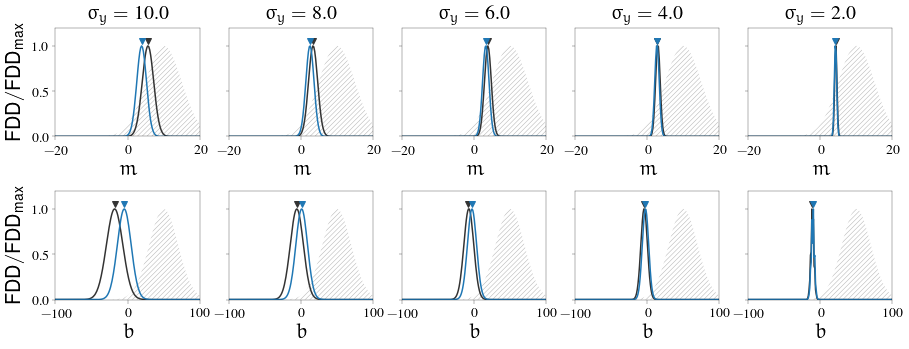

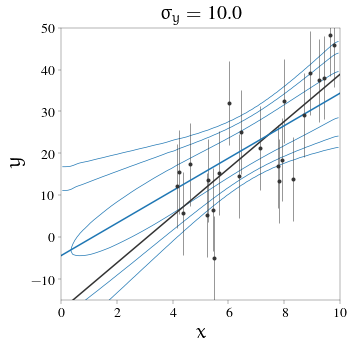

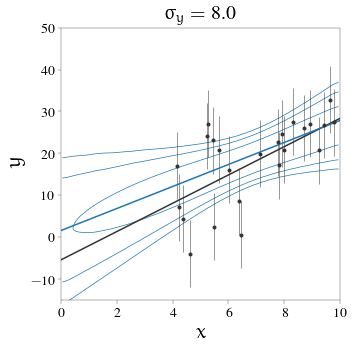

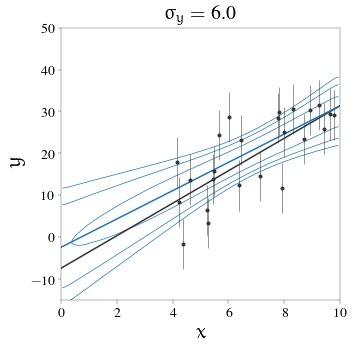

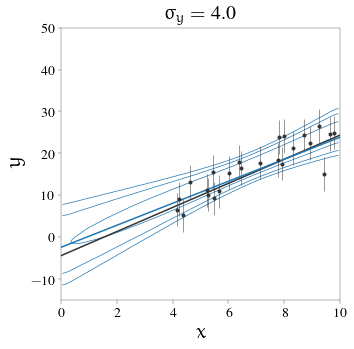

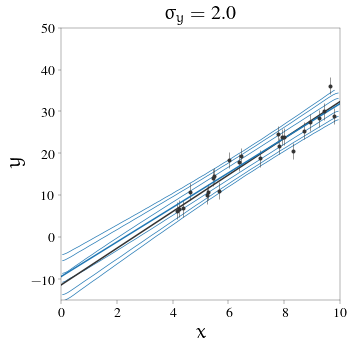

In [5]:
# ======================================== DATA SIMULATION =============================================================
range_x = (0, 10)
range_y = (-15, 50)
range_m, range_b = (-50.0, +50.0), (-200.0, +200.0)
range_pdf = (0.0, 1.2)
N_obs, N_uni, N_par = 30, 400, 400
shape = (N_uni, N_par, N_par)
X = linspace(range_x[0], range_x[1], shape[0])
M = linspace(range_m[0], range_m[1], shape[1])
B = linspace(range_b[0], range_b[1], shape[2])

random.seed(0)
percentiles = [0.99, 0.95, 0.68]
real_params = (1.5, 0.0)
sk, mu, sigma_max = 0.0, 0.0, 10.0
inf_pars = dict(mu_m=10.0, sigma_m=5.0, mu_b=+50.0, sigma_b=20.0)
#inf_pars = dict(mu_m=10.0, sigma_m=5.0, mu_b=0.0, sigma_b=50.0)
x = sort(X[0]+random.rand(N_obs)*(X[-1]-X[0]))
y = real_model(x, real_params)
mask_linear = x>4.0
x_lin = x[mask_linear]
y_lin = y[mask_linear]
# ======================================================================================================================
# ======================================== PRIOR ANALYSIS ==============================================================
fig_pdf, axs = subplots(2, 5, figsize=(15,5), sharex="row", sharey=True)
for ax in axs.ravel(): ax.set_visible(False)
fig_pdf.subplots_adjust(wspace=0.2, hspace=0.5)

axs[0,0].set_ylabel(r"$\text{FDD}/\text{FDD}_\text{max}$")
axs[1,0].set_ylabel(r"$\text{FDD}/\text{FDD}_\text{max}$")
axs[0,0].set_xlim(*(-20,+20))
axs[1,0].set_xlim(*(-100,+100))
axs[0,0].set_ylim(*range_pdf)

var_E = True
show_marglikelihood = True
show_prior = True
show_posterior = True
show_line = True
show_contours = True
save_pdf, save_fit = False, False
mask_names = array([show_marglikelihood, show_prior, show_posterior, show_line, show_contours])
names = array(["mml", "prior", "posterior", "l", "c"])

masks, sigmas, errors = [], [], []
x_idx = digitize(x[mask_linear], linspace(x_lin.min(),x_lin.max(),axs.shape[1]+1), right=True)
x_idx[x_idx==0] = 1
shuffle(x_idx)
for j in xrange(axs.shape[1]):
    if var_E:
        masks.append(x_idx>0)
        sigmas.append(ones(x_lin.size)*(sigma_max-j*2))
        errors.append(skewnorm.rvs(sk, mu, sigma_max-j*2, size=x_lin.size))
    else:
        masks.append(x_idx<=j+1)
        if j==0:
            sigmas.append(ones(x_lin.size)*sigma_max)
            errors.append(skewnorm.rvs(sk, mu, sigma_max, size=x_lin.size))
        else:
            sigmas.append(sigmas[-1])
            errors.append(errors[-1])

for j,i in it.product(xrange(axs.shape[1]),xrange(axs.shape[0])):
    mask = masks[j]
    x_obs = x_lin[mask]
    y_obs = (y_lin + errors[j])[mask]
    s_obs = sigmas[j][mask]
    x_fin = x_lin[~mask]
    y_fin = (y_lin + errors[j])[~mask]
    s_fin = sigmas[j][~mask]
    
    XX_obs, MM_obs, BB_obs = meshgrid(x_obs, M, B, indexing="ij")
    YY_obs, MM_obs, BB_obs = meshgrid(y_obs, M, B, indexing="ij")
    SS_obs, MM_obs, BB_obs = meshgrid(s_obs, M, B, indexing="ij")
    
    likelihood = lik_i(XX_obs,YY_obs,SS_obs,[MM_obs,BB_obs]).prod(axis=0)
    mle_m, mle_b = unravel_index(argmax(likelihood), likelihood.shape)
    
    prior = inf_prior(MM_obs[0], BB_obs[0], **inf_pars)
    posterior = likelihood*prior
    if axs[i,j].is_first_row():
        pri_m = integrate_vol([MM_obs[0],BB_obs[0]], prior, axis=1)
        lik_m = integrate_vol([MM_obs[0],BB_obs[0]], likelihood, axis=1)
        pos_m = integrate_vol([MM_obs[0],BB_obs[0]], posterior, axis=1)
        mml_m = argmax(lik_m)
        map_m = argmax(pos_m)
        
        if var_E: axs[i,j].set_title(r"$\sigma_y={0:.1f}$".format(s_obs.mean()), size="medium")
        else: axs[i,j].set_title(r"$N={0}$".format(mask.sum()), size="medium")
        
        axs[i,j].plot(M, norm_to_max(lik_m), "-", color="0.2", lw=1.5, visible=show_marglikelihood)
        axs[i,j].fill_between(M, norm_to_max(pri_m), lw=0.0, hatch=5*"/", edgecolor="0.7", facecolor="none", visible=show_prior)
        axs[i,j].plot(M, norm_to_max(pos_m), "-", color="C0", lw=1.5, visible=show_posterior)
        axs[i,j].plot(M[mml_m], 1.05, "v", mfc="0.2", mec="0.2", visible=show_marglikelihood)
        axs[i,j].plot(M[map_m], 1.05, "v", mfc="C0", mec="C0", visible=show_posterior)
        axs[i,j].set_xlabel(r"$m$")
    if axs[i,j].is_last_row():
        pri_b = integrate_vol([MM_obs[0],BB_obs[0]], prior, axis=0)
        lik_b = integrate_vol([MM_obs[0],BB_obs[0]], likelihood, axis=0)
        pos_b = integrate_vol([MM_obs[0],BB_obs[0]], posterior, axis=0)
        mml_b = argmax(lik_b)
        map_b = argmax(pos_b)
        
        axs[i,j].plot(B, norm_to_max(lik_b), "-", color="0.2", lw=1.5, visible=show_marglikelihood)
        axs[i,j].fill_between(B, norm_to_max(pri_b), lw=0.0, hatch=5*"/", edgecolor="0.7", facecolor="none", visible=show_prior)
        axs[i,j].plot(B, norm_to_max(pos_b), "-", lw=1.5, color="C0", visible=show_posterior)
        axs[i,j].plot(B[mml_b], 1.05, "v", mfc="0.2", mec="0.2", visible=show_marglikelihood)
        axs[i,j].plot(B[map_b], 1.05, "v", mfc="C0", mec="C0", visible=show_posterior)
        axs[i,j].set_xlabel(r"$b$")
    if i==1:
        fig_fit, ax = subplots(1, 1)
        
        if show_contours and show_posterior:
            PDF_xy, X_pos, Y_pos = model_sampling([MM_obs[0],BB_obs[0]], posterior, X, model)
            XX_pos, YY_pos = meshgrid(X_pos, Y_pos, indexing="ij")
            levels = [percentile_to_level(XX_pos, YY_pos, gaussian_filter(PDF_xy,1.5), per) for per in percentiles]
            ax.contour(X_pos, Y_pos, gaussian_filter(PDF_xy,1.5), levels, colors="C0", linewidths=0.7)
        
        ax.plot(X, model(X, [M[mml_m],B[mml_b]]), "-", color="0.2", lw=1.5, visible=show_marglikelihood&show_line)
        ax.plot(X, model(X, [M[map_m],B[map_b]]), "-", color="C0", lw=1.5, visible=show_posterior&show_line)
        ax.errorbar(x_fin, y_fin, s_fin, fmt=".", ecolor="0.7", color="0.7", lw=0.5)
        ax.errorbar(x_obs, y_obs, s_obs, fmt=".", ecolor="0.2", color="0.2", lw=0.5)
        ax.set_xlim(*range_x)
        ax.set_ylim(*range_y)
        if var_E: ax.set_title(r"$\sigma_y={0:.1f}$".format(s_obs.mean()), size="medium")
        else: ax.set_title(r"$N={0}$".format(mask.sum()), size="medium")
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$y$")
        
        axs[0,j].set_visible(True)
        axs[1,j].set_visible(True)
        
        if save_fit:
            if var_E: fig_fit.savefig("img/var_e-fit-{}-{}".format(join(names[mask_names],"-"), j+1))
            else: fig_fit.savefig("img/var_n-fit-{}-{}".format(join(names[mask_names],"-"), j+1))
        if any(mask_names) and save_pdf:
            if var_E: fig_pdf.savefig("img/var_e-pdf-{}-{}".format(join(names[mask_names],"-"), j+1))
            else: fig_pdf.savefig("img/var_n-pdf-{}-{}".format(join(names[mask_names],"-"), j+1))

In [6]:
# PARA MLE
# en cada iteración:
#X mostrar el ajuste lineal
#X mostrar de la verosimilitud
# explicar como se llega al máximo de la verosimilitud
# explicar que rara vez se cuenta con buen muestreo de la verosimilitud en el espacio de parámetros
# explicar que la incertidumbre en los parámetros no es realista porque no hay propagación

# PARA EXPLICAR MARGINALIZACIÓN
#X mostrar el plano [m,b]
#X mostrar la solución MLE en [m,b]
#X mostrar los contornos de la verosimilitud
# explicar que no se puede conocer con infinita precisión ambos parámetros simultáneamente porque están degenerados
#X mostrar verosimilitud de m, condicional en varios valores de b
#X mostrar verosimilitud de b, condicional en varios valores de m
#X mostrar en ambos casos la distribución marginalizada
# explicar que la marginalización es una forma de propagar la incertidumbre de un parámetro a otro
# explicar que el máximo de la verosimilitud es el mejor punto de partida para muestrear el espacio de parámetros:
# todo se ve mejor desde la cima

# PARA BAYES
# en cada iteración:
#X mostrar el ajuste lineal con los intervalos de confianza (muestrear la distribución posterior para esto)
#X mostrar la distribución previa
#X mostrar la verosimilitud (condicional y marginalizada)
#X mostrar la distribución posterior
# explicar que el parecido entre la verosimilitud y la distribución posterior es un efecto muy deseado
# explicar las interpretaciones de la verosimilitud como función y como distribución de probabilidad y su rol para Bayes
# explicar que Bayes es la actualización de la distribución previa a través del peso impuesto por los datos
# explicar la diferencia entre la verosimilitud y la distribución posterior:
# la verosimilitud es la respuesta a ¿qué tan probables son las observaciones suponiendo que estos son Gaussianos
# y que el modelo y los parámetros propuestos representan el universo de observaciones?
# la distribución posterior, en cambio, es la respuesta a ¿qué tan probables son estos parámetros para describir
# las observaciones hechas, suponiendo que estos obedecen al modelo propuesto?
# con Bayes se reconoce que hay incertidumbre sobre los parámetros y se les da un carácter probabilístico, no así con MV

# PARA EFECTO DE LA DISTRIBUCIÓN PREVIA
# usar una distribución previa informativa y mask_linear
# fijando SNR (alta) y variando N, en cada iteración:
#X mostrar el ajuste lineal con los intervalos de confianza
#X mostrar la distribución posterior
# explicar que en el límite de N infinito, la distribución previa no es relevante siempre que las observaciones sean
# informativas sobre los parámetros y el modelo sea el correcto
# fijando N y variando SNR, en cada iteración:
#X mostrar el ajuste lineal con los intervalos de confianza
#X mostrar la distribución posterior
# explicar que en el límite de SNR infinito, la distribución previa no es relevante siempre que las N observaciones sean
# informativas sobre los parámetros y el modelo sea el correcto

# PARA EXPLICAR EL MÉTODO DE MÁXIMA ENTROPÍA
# plantear el problema de la FIM
# usar el método de los multiplicadores de Lagrange para conseguir la FIM de Salpeter
# explicar que esto sugiere que la FIM tiene un origen estocástico

# PARA VALORACIÓN DEL MODELO
# simular datos con muy buena SNR usando la máscara mask_potent
# usando varios ejempos de distribución previa informativa:
# mostrar el ajuste lineal con los intervalos de confianza en cada caso
# mostrar el modelo real
# explicar que usando una buena distribución previa, no es posible incluir el efecto de haber elegido mal el modelo
# explicar como valorar el modelo usando la distribución posterior predictiva
# mostrar la probabilidad de haber observado los nuevos datos si estos estuvieran basados en el modelo lineal
# explicar que la distribución posterior predictiva puede verse como la aplicación de Bayes usando la distribución
# posterior como distribución previa, permitiendo actualizar el modelo usando la verosimilitud correcta.